In [1]:
import sys
sys.path.append('../..')
import ugent
import matplotlib.pyplot as plt

In [2]:
from strands import Schrodinger2D, Rectangle, Circle
import numpy as np
import math

best_known = 2*np.array([0.99859477260462, 1.99007676008316, 1.99007676008316, 2.95624298898781, 2.98532642806441, 2.98532642806442, 3.92596372109113, 3.92596372109114, 3.98241728327456, 3.98576092607719, 4.87014400547251, 4.89864420444642, 4.89864420444642, 4.98625101494171, 4.98625101494172, 5.81701909971053, 5.81701909971054, 5.86701480916528, 5.88144609873667, 5.99132695571450, 5.99132695571450, 6.73791623075037, 6.76486656303911, 6.76486656303911, 6.85343062732831, 6.85343062732831, 6.99893192820090, 6.99938690825129, 7.65948550690946, 7.65948550690947, 7.69772136553152, 7.73688473693607, 7.83273518682762, 7.83273518682763, 8.00942477463143, 8.00942477463144, 8.55402322299586, 8.57635148658287, 8.57635148658294, 8.67792887113521, 8.67792887113523, 8.81132713081544, 8.81518847088363, 9.02172330707064, 9.02172330707064, 9.44405461567860])

f = 1/(6*math.sqrt(5))
def V(x, y):
    return x*x + y*y + f*y*(3*x*x - y*y)


In [3]:
m = 48, 64

s = Schrodinger2D(V, Rectangle(-6,6, -6,6), # Circle(9.5),
                  gridSize=(48, 48), maxBasisSize=36)

eigenvalues = np.array(s.eigenvalues(k=40, shiftInvert=False, sparse=True))
eigenvalues - best_known[:len(eigenvalues)]

array([3.66373598e-13, 2.85238499e-12, 4.55524507e-11, 1.25158817e-09,
       5.18625143e-11, 1.27811006e-09, 3.49021523e-09, 5.80393973e-08,
       2.24862013e-08, 8.04250888e-10, 6.64840202e-07, 4.18703543e-08,
       9.41695584e-07, 2.94343483e-08, 2.22393968e-07, 1.12491010e-06,
       1.69791000e-05, 9.73112651e-06, 4.22221220e-07, 2.41765798e-07,
       2.05797160e-06, 1.03343320e-04, 9.67104673e-06, 1.77938712e-04,
       9.79763005e-06, 4.43377177e-05, 3.04700953e-06, 1.30797522e-05,
       1.31581331e-04, 1.52603788e-03, 1.00842903e-03, 6.04894225e-05,
       6.05008842e-05, 2.77137036e-04, 2.52149078e-05, 6.55614937e-05,
       4.45192680e-03, 8.37478757e-04, 1.06650813e-02, 8.35458962e-04])

In [3]:
from tqdm.notebook import tqdm
import random
import time
import pickle

tic_toc_start = 0

def tic():
    global tic_toc_start
    tic_toc_start = time.time_ns()

def toc():
    end = time.time_ns()
    return (end - tic_toc_start)/1000/1000/1000


def V(x, y):
    return x*x + y*y + f*y*(3*x*x - y*y)

domain = Rectangle(-6,6, -6,6)

def test(N):
    print(N)
    m = N * 3 // 4
    tic()
    s = Schrodinger2D(V, domain, gridSize=(N, N), maxBasisSize=m)
    ctime = toc()
    
    times = {}
    r = [False, True]
    random.shuffle(r)
    for shiftInvert in r:
        tic()
        eigs = s.eigenvalues(k=40, sparse=True, shiftInvert=shiftInvert)
        etime = toc()
        times[shiftInvert] = etime
        
    return ctime, (times[False], times[True])

from_pickle = True

pickle_file = "benchmark_results.pckl"
if from_pickle:
    with open(pickle_file, 'rb') as p:
        results = pickle.load(p)
else:
    Ns = [32,48, 64,80,96, 112] * 5
    random.shuffle(Ns)
    results = {N: [] for N in Ns}
    for N in tqdm(Ns):
        results[N].append(test(N))
    with open(pickle_file, "wb") as p:
        pickle.dump(results, p)
        
print(results.keys())

dict_keys([64, 112, 96, 80, 48, 32])


In [4]:
points = sorted(results.keys())
summary = [[], [], []]
errors = [[], [], []]
for p in points:
    s = [[],[],[]]
    for constructor, (select, shift) in results[p]:
        s[0].append(constructor)
        s[1].append(select)
        s[2].append(shift)
    for i in range(3):
        l, h = min(s[i]), max(s[i])
        summary[i].append((l + h)/2)
        errors[i].append((h-l)/2)

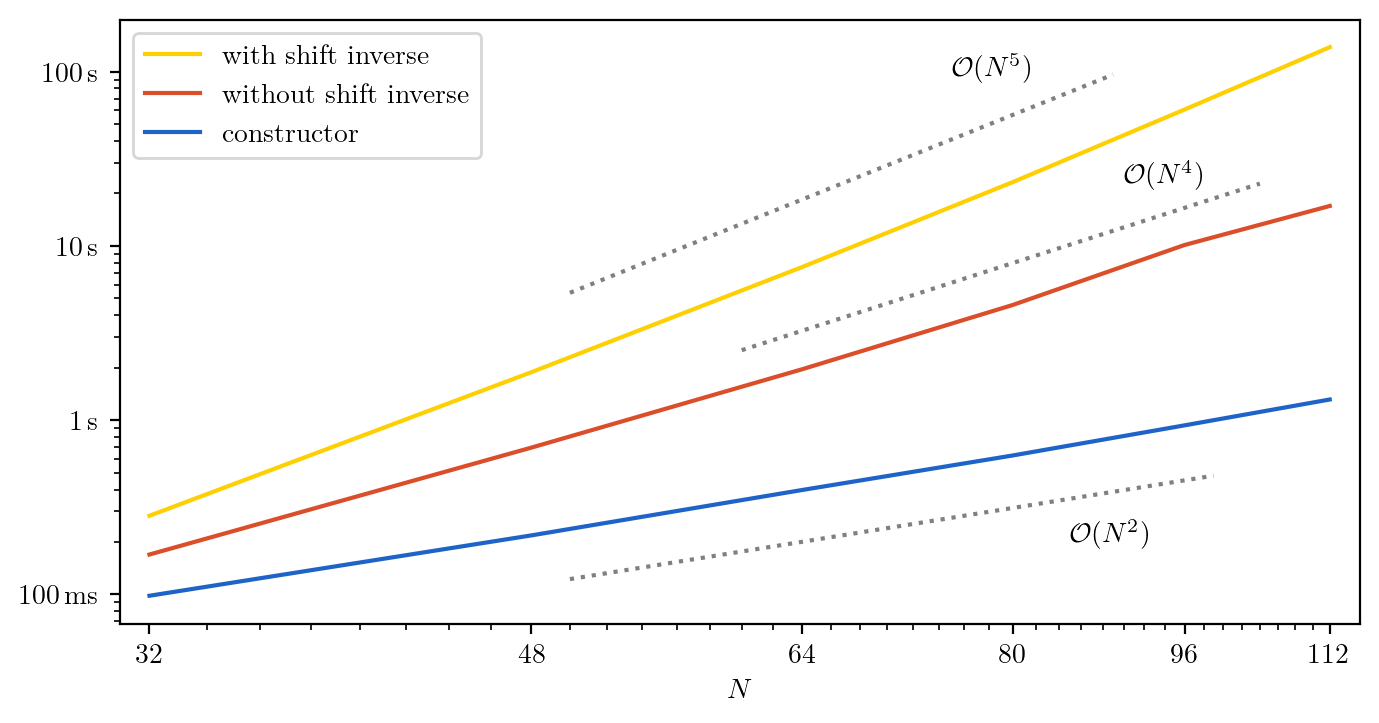

In [9]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch

fig = plt.figure(figsize=(8, 4), dpi=200)
ax = fig.gca()

for i, label in enumerate(["constructor", "without shift inverse", "with shift inverse"]):
    vertices = []
    for d, j in list(zip([1]*len(points), range(len(points)))) + list(zip([-1]*len(points), range(len(points))))[::-1]:
        vertices.append((points[j], summary[i][j] + d * errors[i][j]))
    codes = np.full(len(vertices), Path.LINETO)
    codes[0] = Path.MOVETO
    path = Path(vertices, codes)
    ax.add_patch(PathPatch(path, color=ugent.palet[i], alpha=0.4, lw=0))
    
    
    ax.loglog(points, summary[i], label=label, color=ugent.palet[i])

xs1 = np.arange(50, 100)
ax.plot(xs1, (0.007*xs1)**2, c="gray", ls=':')
ax.text(85, 0.2, "$\\mathcal{O}(N^{2})$")
xs2 = np.arange(60, 105)
ax.plot(xs2, (0.021*xs2)**4, c="gray", ls=':')
ax.text(90, 23, "$\\mathcal{O}(N^{4})$")
xs3 = np.arange(50, 90)
ax.plot(xs3, (0.028*xs3)**5, c="gray", ls=':')
ax.text(75, 95, "$\\mathcal{O}(N^{5})$")

ax.set_yticks([0.1, 1, 10, 100], ["$100\\,\\text{ms}$", "$1\\,\\text{s}$", "10\\,\\text{s}", "100\\,\\text{s}"])
ax.set_xticks(ticks=points, labels=points)
ax.set_xticks(ticks=range(32, 112, 2), labels=[], minor=True)
ax.set_xlabel("$N$")
ax.legend()
ax.set_xlim(31, 115.6)


handles, labels = ax.get_legend_handles_labels()
order = [2,1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.savefig(f"benchmark_timings.pdf", bbox_inches="tight")